In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np   # matrices, math
import os    # file management
import pandas as pd   # data frames
import importlib   # for reloading your own files
from termcolor import colored   # for colored error messages

# my own file:
already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except:
    try:
        import Bubble_dynamics_simulation.full_bubble_model as de
    except:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
if already_imported: importlib.reload(de)   # reload changes you made

import Bubble_dynamics_simulation.excitation as ex

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [14]:
file_base_name = 'output_'
directory = r'D:\parameter_studies\Excitation_search'
folders = [folder for folder in os.listdir(directory)]
dfs = []
for folder in folders:
    df = pd.DataFrame()
    file_lens = []
    mins = []
    for file in os.listdir(os.path.join(directory, folder)):
        if file.startswith(file_base_name) and file.endswith('.csv'):
            try:
                current_data = pd.read_csv(os.path.join(directory, folder, file))
            except:
                print(colored(f'Error, could not read file {folder} / {file}', 'red'))
            for col in current_data.columns:
                if current_data[col].dtype == 'object' and all(current_data[col].dropna().map(lambda x: isinstance(x, bool))):
                    current_data[col] = current_data[col].astype(bool)
            current_data = current_data.loc[current_data['success'] == True & (current_data['energy_efficiency'] > 0)]
            df = pd.concat([df, current_data])
            file_lens.append(len(current_data))
            mins.append(current_data['energy_efficiency'].min())
    dfs.append(df)
    print(f'{folder}:')
    print(f'    best energy_efficiency:  {df["energy_efficiency"].min(): .4e} MJ/kg')
    mins = np.array(mins)
    file_lens = np.array(file_lens)
    #good = df.loc[df['success'] == True]
    #print(f'    number of good files: {100.0*len(good)/len(df): .2f} %')
    print(f'    avarage best energy_efficiency:  {mins.mean(): .4f} MJ/kg')
    print(f'    max best energy_efficiency:  {mins.max(): .4f} MJ/kg')
    print(f'    average file length: {file_lens.mean(): .2f} rows')

no_excitation:
    best energy_efficiency:   3.5878e+03 MJ/kg
    avarage best energy_efficiency:   3606.2653 MJ/kg
    max best energy_efficiency:   3827.1248 MJ/kg
    average file length:  513.48 rows
sin_impulse_1:
    best energy_efficiency:   8.6998e+02 MJ/kg
    avarage best energy_efficiency:   988.4009 MJ/kg
    max best energy_efficiency:   1401.4460 MJ/kg
    average file length:  413.98 rows
sin_impulse_2:
    best energy_efficiency:   1.1207e+03 MJ/kg
    avarage best energy_efficiency:   1311.7461 MJ/kg
    max best energy_efficiency:   1526.3860 MJ/kg
    average file length:  514.68 rows
sin_impulse_3:
    best energy_efficiency:   9.7654e+02 MJ/kg
    avarage best energy_efficiency:   1286.8092 MJ/kg
    max best energy_efficiency:   1503.0564 MJ/kg
    average file length:  581.65 rows
sin_impulse_4:
    best energy_efficiency:   1.3952e+03 MJ/kg
    avarage best energy_efficiency:   1858.5207 MJ/kg
    max best energy_efficiency:   2127.5121 MJ/kg
    average file le

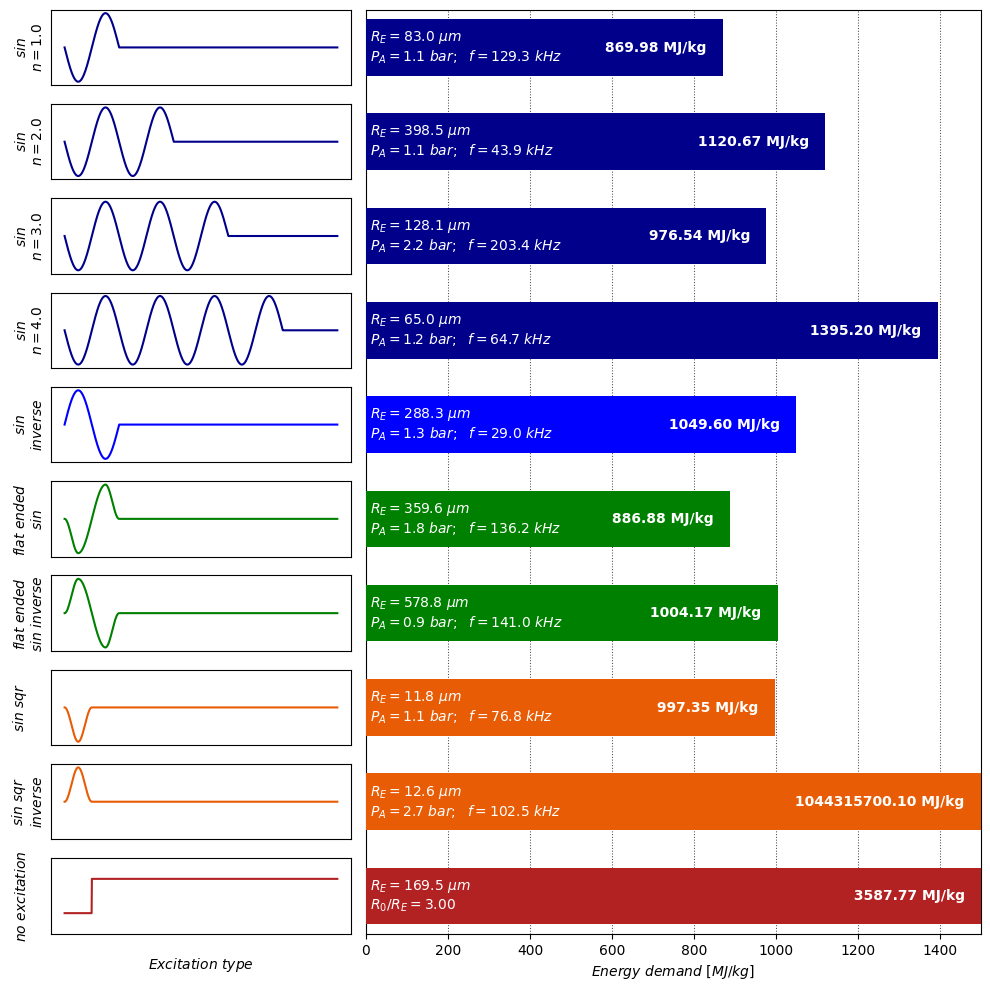

In [20]:
n = 10
max_energy = 1500.0
newfolders = ['sin_impulse_1', 'sin_impulse_2', 'sin_impulse_3', 'sin_impulse_4', 'sin_impulse_inverse', 'sin_impulse_flat_ends',
              'sin_impulse_flat_ends_inverse', 'sin_sqr', 'sin_sqr_inverse', 'no_excitation']

fig = plt.figure(figsize=(12, 1.2*n))
grid = gridspec.GridSpec(n, 3, wspace=0.05, hspace=0.25)    
bar_ax = fig.add_subplot(grid[:, 1:])
ex_axes = []
for i in range(n):
    ex_axes.append(fig.add_subplot(grid[i, 0]))

# Bars
energies = [min(df['energy_efficiency'].min(), max_energy) for df in dfs]
energies = []
for folder in newfolders:
    i = folders.index(folder)
    df = dfs[i]
    energies.append(min(df['energy_efficiency'].min(), max_energy))
colors = []
for folder in newfolders:
    if 'sin_impulse' == folder[:-2]:
        colors.append('darkblue')
    elif 'sin_impulse_inverse' == folder:
        colors.append('blue')
    elif 'sin_impulse_flat_ends' in folder:
        colors.append('green')
    elif 'sin_sqr' in folder:
        # append rgb color code
        colors.append((232/255, 92/255, 5/255))
    elif 'no_excitation' == folder:
        colors.append('firebrick')
    else:
        colors.append('lightblue')

bar_ax.grid(color='k', axis='x', linestyle=':', linewidth=0.75, alpha=0.7, zorder=0)
bar_ax.set_xlim([0.0, max_energy])
bar_ax.set_ylim([-0.1, n-0.3])
bar_ax.barh(newfolders, energies, color=colors, height=0.6, zorder=3, align='edge')
bar_ax.invert_yaxis()
bar_ax.set_xlabel('$Energy \ demand \ [MJ/kg]$')
bar_ax.yaxis.set_ticks_position('none')
bar_ax.set_yticks([])
ex_axes[-1].set_xlabel('\n$Excitation\ type$')

# Texts
for i, bar in enumerate(bar_ax.patches):
    folder = newfolders[i]
    i = folders.index(folder)
    df = dfs[i]
    df.sort_values(by='energy_efficiency')
    best = df.iloc[0]
    text = f'$R_E={1e6*best["R_E"]: .1f}\ \mu m$\n'
    if 'sin_impulse' == folder[:-2]:
        text += f'$P_A={-1e-5*best["p_A"]: .1f}\ bar;\ \ f={1e-3*10**best["logf"]: .1f}\ kHz$'
    elif 'sin_impulse_inverse' == folder:
        text += f'$P_A={1e-5*best["p_A"]: .1f}\ bar;\ \ f={1e-3*10**best["logf"]: .1f}\ kHz$'
    elif 'sin_impulse_flat_ends' == folder:
        text += f'$P_A={-1e-5*best["p_A"]: .1f}\ bar;\ \ f={1e-3*best["freq"]: .1f}\ kHz$'
    elif 'sin_impulse_flat_ends_inverse' == folder:
        text += f'$P_A={1e-5*best["p_A"]: .1f}\ bar;\ \ f={1e-3*best["freq"]: .1f}\ kHz$'
    elif 'sin_sqr' == folder:
        text += f'$P_A={-1e-5*best["p_A"]: .1f}\ bar;\ \ f={1e-3*best["freq"]: .1f}\ kHz$'
    elif 'sin_sqr_inverse' == folder:
        text += f'$P_A={1e-5*best["p_A"]: .1f}\ bar;\ \ f={1e-3*best["freq"]: .1f}\ kHz$'
    elif 'no_excitation' == folder:
        text += f'$R_0/R_E={best["ratio"]: .2f}$'
    
    bar_ax.text(10, bar.get_y()+0.3, text,
             fontsize = 10, fontweight ='normal', verticalalignment='center', horizontalalignment='left',
             color ='white')

    i = folders.index(folder)
    energy = dfs[i]['energy_efficiency'].min()
    bar_ax.text(bar.get_width()-40, bar.get_y()+0.3, 
             f'{energy: .2f} MJ/kg',
             fontsize = 10, fontweight ='bold', verticalalignment='center', horizontalalignment='right',
             color ='white')

# Excitation types
timesteps = np.linspace(0.0, 5.0, 1000)
for i, folder in enumerate(newfolders):
    ex_ax = ex_axes[i]
    ex_axes.append(ex_ax)
    ex_ax.set_xticks([])
    ex_ax.set_yticks([])
    if 'sin_impulse' == folder[:-2]:
        n = float(folder[-1])
        ex_ax.set_ylabel(f'$sin$\n$n={n}$')
        excitation, args, units = ex.getExcitation('sin_impulse')
        values = [excitation(t, 0.0, np.array([-1.0, 1.0, n]))[0] for t in timesteps]
        ex_ax.plot(timesteps, values, color='darkblue')
    elif 'sin_impulse_inverse' == folder:
        ex_ax.set_ylabel('$sin$\n$inverse$')
        excitation, args, units = ex.getExcitation('sin_impulse')
        values = [excitation(t, 0.0, np.array([1.0, 1.0, 1.0]))[0] for t in timesteps]
        ex_ax.plot(timesteps, values, color='blue')
    elif 'flat_ends' in folder:
        excitation, args, units = ex.getExcitation('sin_impulse_flat_ends')
        if 'inverse' in folder:
            ex_ax.set_ylabel('$flat\ ended$\n$sin\ inverse$')
            values = [excitation(t, 0.0, np.array([1.0, 1.0, 1.0]))[0] for t in timesteps]
        else:
            ex_ax.set_ylabel('$flat\ ended$\n$sin$')
            values = [excitation(t, 0.0, np.array([-1.0, 1.0, 1.0]))[0] for t in timesteps]
        ex_ax.plot(timesteps, values, color='green')
    elif 'sin_sqr' in folder:
        excitation, args, units = ex.getExcitation('sin_sqr')
        ex_ax.set_ylim([-1.1, 1.1])
        if 'inverse' in folder:
            ex_ax.set_ylabel('$sin\ sqr$\n$inverse$')
            values = [excitation(t, 0.0, np.array([1.0, 1.0, 0.5]))[0] for t in timesteps]
        else:
            ex_ax.set_ylabel('$sin\ sqr$\n')
            values = [excitation(t, 0.0, np.array([-1.0, 1.0, 0.5]))[0] for t in timesteps]
        ex_ax.plot(timesteps, values, color=(232/255, 92/255, 5/255))
    elif 'no_excitation' == folder:
        ex_ax.set_ylabel('$no\ excitation$\n')
        ex_ax.set_ylim([-1.1, 1.1])
        values = []
        for t in timesteps:
            values.append(-0.5 if t < 0.5 else 0.5)
        ex_ax.plot(timesteps, values, color='firebrick')

plt.show()
fig.savefig(r"D:\BME_OneDrive\BME-7\Szakdolgozat\excitation.svg", bbox_inches='tight')